In [1]:
%matplotlib inline 
import pickle
import os
import numpy as np
import json
from PIL import Image,ImageDraw
import sys

import cv2
import matplotlib.pyplot as plt  
import matplotlib.patches as patches

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.measure import find_contours

from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import box

In [2]:
from random import sample

In [161]:
imagePath = r'C:\Users\jiali\Desktop\choroColorRead\generatedMaps\quantiles'
imageName = 'ohio_RdBu_4_pos_large.jpg'
# testImages = os.listdir(imagePath)

In [162]:
# read detection results from pickle file
detectResultsPath = r'D:\OneDrive - The Ohio State University\choroColorRead'
detectResultFileName = 'detectResultSpatialPattern.pickle'
with open(detectResultsPath + '\\' + detectResultFileName, 'rb') as f:
    detectResults = pickle.load(f)

In [163]:
detectResult = detectResults[4]

In [164]:
property = detectResult[1]
boxes = property['rois']
masks = property['masks']
class_ids = property['class_ids']

# extract mask for mapping area
N = boxes.shape[0]
if not N:
    print("\n*** No instances to display *** \n")
else:
    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

image = cv2.imread(imagePath + '\\' + imageName)
imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

masked_image = image.astype(np.uint32).copy()
maskPolyList = []

In [165]:
image.shape

(966, 1576, 3)

In [166]:
height = image.shape[0]
print(height)
width = image.shape[1]
print(width)

966
1576


In [167]:
# get the polygon for mapping area
for i in range(N):
#     if i > 0:
#         continue
    if class_ids[i] != 3:
        continue
    # Bounding box
    if not np.any(boxes[i]):
        # Skip this instance. Has no bbox. Likely lost in image cropping.
        continue
    y1, x1, y2, x2 = boxes[i]
    bboxMap = box(x1, y1, x2, y2)
    # Mask
    mask = masks[:, :, i]

    # Mask Polygon
    # Pad to ensure proper polygons for masks that touch image edges.
    padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = find_contours(padded_mask, 0.5)
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        vertList = [(vert[0],vert[1]) for vert in verts]
        maskPolygon = Polygon(vertList)
        maskPolyList.append(maskPolygon)

In [168]:
maskPolygon.area

468606.5

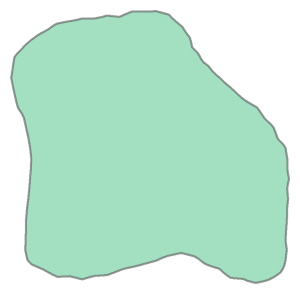

In [169]:
maskPolygon

In [172]:
# rgb color list
colorList = [[146, 198, 222], [244, 166, 130], [201, 0, 32], [7, 112, 177]] # the third color is the darkest one
# colorList = [[191, 214, 230], [107, 174, 216], [33, 114, 180], [239, 243, 255]]

In [171]:
def bgr2rgb(value):
    return value[2],value[0],value[1]
def valueEqualColor(value,color):
    colorR, colorG, colorB = color[0], color[1], color[2]
    valueR, valueG, valueB = value[0], value[1], value[2]
    if abs(colorR - valueR) > 10 or abs(colorB - valueB) > 10 or abs(colorG - valueG) > 10:
        return False
    else:
        return True

In [14]:
def rgb2Grey(dominantColor):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    dominantColorGrey = int(np.dot(dominantColor, rgb_weights))
    return dominantColorGrey

In [173]:
# traverse the whole image
colorGrey0 = rgb2Grey(colorList[0])
colorGrey1 = rgb2Grey(colorList[1])
colorGrey2 = rgb2Grey(colorList[2])
colorGrey3 = rgb2Grey(colorList[3])
colorGreyList = [rgb2Grey(color) for color in colorList]

In [180]:
pixelCoordList0, pixelCoordList1, pixelCoordList2, pixelCoordList3 = [],[],[],[]
pixelCoordsList = [[] for i in range(len(colorGreyList)) ] # a set of coords for each color class
for i in range(height):
    if i % 100 == 0:
        print(i)
    for j in range(mask.shape[1]):
        # test x,y axis
#         if i != 148 or j != 257:
#             continue
        point = Point(j,i)
        
#         if bboxMap.contains(point) and maskPolygon.contains(point):
        if mask[i,j] == True:
#             print('yes!')
            value =  imageGray[i,j]
#             print(value)
            b, g, r = image[i,j]
#             value_rgb = value
#             print(value_rgb)
            if not (abs(b - g) < 10 and abs(b-r) < 10 and abs(g - r)<10):
                for k in range(len(colorGreyList)):
                    if abs(value - colorGreyList[k]) <= 10:
                        colorB, colorG, colorR = colorList[k]
                        if abs(b - colorB) > 10 and abs(g - colorG) > 10 and abs(r - colorR) > 10:
                            continue
                        else:
                            pixelCoordsList[k].append((j,i))
                        break
#                 if abs(value - colorGrey0) <= 10:
# #                     print('0: j: '+ str(j) + ' i: ' + str(i))
#                     pixelCoordList0.append((j,i))  
#                 elif abs(value - colorGrey1) <= 10:
# #                     print('1: j: '+ str(j) + ' i: ' + str(i))
#                     pixelCoordList1.append((j,i))  
#                 elif abs(value - colorGrey2) <= 10:
# #                     print('0: j: '+ str(j) + ' i: ' + str(i))
#                     pixelCoordList2.append((j,i))  
#                 elif abs(value - colorGrey3) <= 10:
# #                     print('0: j: '+ str(j) + ' i: ' + str(i))
#                     pixelCoordList3.append((j,i))  

0


C:\Users\jiali\anaconda3\envs\imageProcess\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in ubyte_scalars


100
200
300
400
500
600
700
800
900


In [181]:
pixelCoordList0, pixelCoordList1,pixelCoordList2,pixelCoordList3 = pixelCoordsList[0],pixelCoordsList[1],pixelCoordsList[2],pixelCoordsList[3]

In [182]:
pixelCoordList0_sample = sample(pixelCoordList0,int(len(pixelCoordList0)/100))
pixelCoordList1_sample = sample(pixelCoordList1,int(len(pixelCoordList1)/100))
pixelCoordList2_sample = sample(pixelCoordList2,int(len(pixelCoordList2)/100))
pixelCoordList3_sample = sample(pixelCoordList3,int(len(pixelCoordList3)/100))

In [183]:
pixelCoordList_sample = pixelCoordList0_sample + pixelCoordList1_sample + pixelCoordList2_sample + pixelCoordList3_sample

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

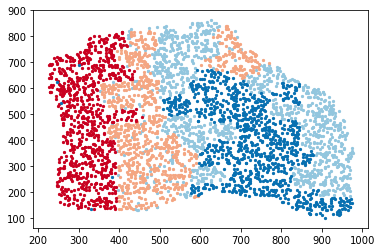

In [184]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [pixelCoord[0] for pixelCoord in pixelCoordList0_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList0_sample]
ax.scatter(xList, yList, s = 5,c = np.asarray(colorList[0])/255.0)

xList = [pixelCoord[0] for pixelCoord in pixelCoordList1_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList1_sample]
ax.scatter(xList, yList, s = 5,c = np.asarray(colorList[1])/255.0)

xList = [pixelCoord[0] for pixelCoord in pixelCoordList2_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList2_sample]
ax.scatter(xList, yList, s = 5,c = np.asarray(colorList[2])/255.0)

xList = [pixelCoord[0] for pixelCoord in pixelCoordList3_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList3_sample]
ax.scatter(xList, yList, s = 5,c = np.asarray(colorList[3])/255.0)
plt.show()

### calculate pair-wise shortest path

In [185]:
import math

In [186]:
def distance(coord1, coord2):
    x1, y1 = coord1[0], coord1[1]
    x2, y2 = coord2[0], coord2[1]
    dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return dist

In [187]:
from sklearn.neighbors import KDTree

In [188]:
import statistics

### calculate distance list for random distribution in the region

In [24]:
import alphashape

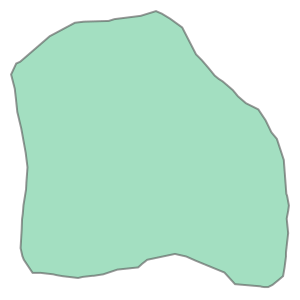

In [25]:
alpha_shape = alphashape.alphashape(pixelCoordList_sample, 0.01) # convex hull
alpha_shape

In [26]:
xList = [pixelCoord[0] for pixelCoord in pixelCoordList_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList_sample]
xMin, xMax = min(xList), max(xList)
yMin, yMax = min(yList), max(yList)
yMid = int((yMin + yMax) / 2)
xMin, xMax, yMin, yMax, yMid

(220, 983, 105, 863, 484)

In [27]:
import random
print(random.randint(0,9))

6


In [28]:
numPoints

NameError: name 'numPoints' is not defined

In [ ]:
randomPointList = []
while len(randomPointList) < numPoints:
    x = random.randint(xMin,int(xMax-(xMax-xMin) /2) )
    y = random.randint(yMin,int(yMax-(yMax-yMin) /2) )
    point = Point(x,y)
    if alpha_shape.contains(point):
        randomPointList.append(point)
len(randomPointList)

NameError: name 'randomPointList' is not defined

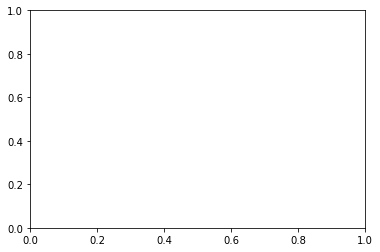

In [29]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [pixelCoord.x for pixelCoord in randomPointList]
yList = [pixelCoord.y for pixelCoord in randomPointList]
ax.scatter(xList, yList, s = 5,c = 'blue')

plt.show()

In [35]:
X = np.array([[pixelCoord.x,pixelCoord.y] for pixelCoord in randomPointList])
kdt = KDTree(X, leaf_size=30, metric='euclidean')
queryResultsAllRandom = kdt.query(X, k=numPoints, return_distance=True)
distanceArrayAllRandom = queryResultsAllRandom[0]
distanceListAllRandom = distanceArrayAllRandom.tolist()
distanceListAllRandom = [distanceAllRandom[1] for distanceAllRandom in distanceListAllRandom]
distanceListAllRandom

[1.4142135623730951,
 2.23606797749979,
 6.082762530298219,
 5.656854249492381,
 13.038404810405298,
 3.605551275463989,
 1.0,
 2.23606797749979,
 2.8284271247461903,
 13.0,
 4.123105625617661,
 5.385164807134504,
 4.123105625617661,
 1.0,
 7.280109889280518,
 2.23606797749979,
 5.656854249492381,
 2.8284271247461903,
 10.04987562112089,
 5.830951894845301,
 3.1622776601683795,
 3.0,
 2.23606797749979,
 2.8284271247461903,
 2.23606797749979,
 7.0,
 8.246211251235321,
 6.0,
 2.8284271247461903,
 4.0,
 7.810249675906654,
 1.0,
 10.04987562112089,
 6.708203932499369,
 3.1622776601683795,
 2.8284271247461903,
 4.47213595499958,
 3.0,
 6.0,
 9.486832980505138,
 7.280109889280518,
 8.246211251235321,
 5.656854249492381,
 5.656854249492381,
 5.385164807134504,
 10.04987562112089,
 5.0,
 1.0,
 7.280109889280518,
 6.082762530298219,
 2.0,
 2.0,
 7.211102550927978,
 3.1622776601683795,
 4.123105625617661,
 10.770329614269007,
 6.082762530298219,
 6.4031242374328485,
 3.0,
 5.0990195135927845,
 4

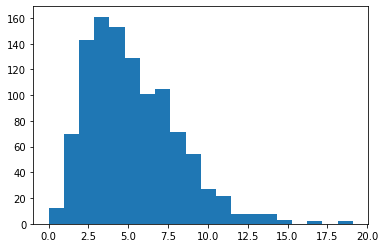

In [36]:
plt.hist(distanceListAllRandom, 20)
plt.show()

### clustering for k function 

In [189]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [190]:
sil = []
difSilList = []
kmax = 100
x = pixelCoordList0_sample
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
#     print('K: '+str(k))
    kmeans = KMeans(n_clusters = k,random_state=0).fit(x)
    labels = kmeans.labels_
    silScore = silhouette_score(x, labels, metric = 'euclidean')
    difSil = 0
    if len(sil) > 0:
        difSil = silScore - sil[-1]
    sil.append(silScore)
    difSilList.append(difSil)
print(sil)

# find the best index of difSil
index = 0
maxValue = max(sil)
maxIndex = sil.index(maxValue)
maxDif = max(difSilList)
while maxIndex >= 3:
    maxValue = sil[maxIndex]
    i = maxIndex - 1
    if difSilList[maxIndex] < maxDif / 10:
        maxIndex = maxIndex - 1
    else:
        break
numClusters = maxIndex + 2
kmeans0 = KMeans(n_clusters = numClusters).fit(x)
kmeans0.cluster_centers_

[0.5385957453506064, 0.553947726539344, 0.5344100300223328, 0.5099923730957381, 0.47778012080886095, 0.4737315591797256, 0.4590151609416641, 0.44307083571178985, 0.44517004080643036, 0.4223403094439701, 0.4335862593513447, 0.4254693584250117, 0.44265161371524175, 0.4348029420387412, 0.4431722478142133, 0.43795509733537935, 0.44471358583819937, 0.4411292838337978, 0.44837168028059116, 0.4381772023688351, 0.453920897543653, 0.4442077928740025, 0.43637105280086985, 0.4318339294969476, 0.4254418478869461, 0.4305454245745882, 0.4334184374923548, 0.4200418862980145, 0.4315160579447526, 0.42998250428281637, 0.42367868499390643, 0.41077354859960974, 0.4232878017956488, 0.41436002610447464, 0.409431093643119, 0.41020404050090914, 0.41068083895510654, 0.4036802912786567, 0.4114078954300167, 0.4059608077654561, 0.4082054540179187, 0.3955222515130063, 0.3978967218766151, 0.3969762154518116, 0.4028048323375369, 0.3840245814350258, 0.4034327662231823, 0.39698689459256453, 0.4054420895875868, 0.38805

array([[891.97613883, 396.15401302],
       [583.88968825, 709.95443645],
       [572.38628159, 367.96389892]])

In [191]:
sil = []
difSilList = []
kmax = 100
x = pixelCoordList1_sample
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
#     print('K: '+str(k))
    kmeans = KMeans(n_clusters = k,random_state=0).fit(x)
    labels = kmeans.labels_
    silScore = silhouette_score(x, labels, metric = 'euclidean')
    difSil = 0
    if len(sil) > 0:
        difSil = silScore - sil[-1]
    sil.append(silScore)
    difSilList.append(difSil)
print(sil)

# find the best index of difSil
index = 0
maxValue = max(sil)
maxIndex = sil.index(maxValue)
maxDif = max(difSilList)
while maxIndex >= 3:
    maxValue = sil[maxIndex]
    i = maxIndex - 1
    if difSilList[maxIndex] < maxDif / 10:
        maxIndex = maxIndex - 1
    else:
        break
numClusters = maxIndex + 2
kmeans1 = KMeans(n_clusters = numClusters).fit(x)
kmeans1.cluster_centers_

[0.5739139167162374, 0.4961879049336747, 0.5065628427733512, 0.4740122078288178, 0.4755560168241757, 0.4453215405841928, 0.48234028884008334, 0.45148959200062677, 0.4489823655498757, 0.4400276672007058, 0.4340857234987587, 0.43183504266077893, 0.42127848974659055, 0.42204088266742457, 0.4221735197998888, 0.4206510859834456, 0.43426617360328196, 0.4307809197484107, 0.43644523768656307, 0.4363735493957159, 0.432895463040585, 0.435601293962626, 0.42988207845249, 0.4270192267572699, 0.43065196116263854, 0.4315202786810629, 0.4207385511570059, 0.41793117632617377, 0.4119905964245795, 0.4003097037844851, 0.4068192980398178, 0.40698800452307615, 0.40128852722789704, 0.398260148818641, 0.3894344979437089, 0.3966230667188408, 0.40161054558063186, 0.3996469770650368, 0.38564737004409866, 0.40267803710879746, 0.39007103359457174, 0.391993966447079, 0.39950997559738105, 0.39524507416595295, 0.402601394923427, 0.39717443356360604, 0.38688454205497874, 0.39127092450618994, 0.38634326804246755, 0.389

array([[473.475     , 319.29375   ],
       [522.43434343, 673.13131313]])

In [192]:
sil = []
difSilList = []
kmax = 100
x = pixelCoordList2_sample
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
#     print('K: '+str(k))
    kmeans = KMeans(n_clusters = k,random_state=0).fit(x)
    labels = kmeans.labels_
    silScore = silhouette_score(x, labels, metric = 'euclidean')
    difSil = 0
    if len(sil) > 0:
        difSil = silScore - sil[-1]
    sil.append(silScore)
    difSilList.append(difSil)
print(sil)

# find the best index of difSil
index = 0
maxValue = max(sil)
maxIndex = sil.index(maxValue)
maxDif = max(difSilList)
while maxIndex >= 3:
    maxValue = sil[maxIndex]
    i = maxIndex - 1
    if difSilList[maxIndex] < maxDif / 10:
        maxIndex = maxIndex - 1
    else:
        break
numClusters = maxIndex + 2
kmeans2 = KMeans(n_clusters = numClusters).fit(x)
kmeans2.cluster_centers_

[0.502312109172067, 0.44383167626773923, 0.4128413489141574, 0.38083613369034647, 0.3696159807374257, 0.3858074512786655, 0.3971263931252825, 0.40431239741469, 0.4049320100159612, 0.4043571133493522, 0.397614608350354, 0.38060599225422675, 0.37666785176294226, 0.38729365774494173, 0.3836848682378384, 0.37730953781237453, 0.3923104169279897, 0.38062393077608864, 0.38194245183191555, 0.3894433413621862, 0.3843602356121794, 0.38141999252717196, 0.3844683877412421, 0.3933472571734005, 0.38057013407027424, 0.3849275779576727, 0.3901677967896134, 0.3893183649563442, 0.3940507759244003, 0.3831594930203788, 0.3902020064551961, 0.39418763470363855, 0.39757458081483743, 0.3925695637545299, 0.3923918856031512, 0.3892147623983846, 0.3895748668982191, 0.3895463915654173, 0.3808927234895505, 0.38391610230861634, 0.3817291235489103, 0.387068064074795, 0.39135728232589917, 0.37970938020225975, 0.3822120995121726, 0.3861571574644935, 0.3841036796999346, 0.3854343350670271, 0.3899516171187978, 0.3907518

array([[324.45549738, 289.26439791],
       [326.96170213, 627.88723404]])

In [193]:
sil = []
difSilList = []
kmax = 100
x = pixelCoordList3_sample
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(3, kmax+1):
#     print('K: '+str(k))
    kmeans = KMeans(n_clusters = k,random_state=0).fit(x)
    labels = kmeans.labels_
    silScore = silhouette_score(x, labels, metric = 'euclidean')
    difSil = 0
    if len(sil) > 0:
        difSil = silScore - sil[-1]
    sil.append(silScore)
    difSilList.append(difSil)
print(sil)

# find the best index of difSil
index = 0
maxValue = max(sil)
maxIndex = sil.index(maxValue)
maxDif = max(difSilList)
while maxIndex >= 3:
    maxValue = sil[maxIndex]
    i = maxIndex - 1
    if difSilList[maxIndex] < maxDif / 10:
        maxIndex = maxIndex - 1
    else:
        break
numClusters = maxIndex + 2
kmeans3 = KMeans(n_clusters = numClusters).fit(x)
kmeans3.cluster_centers_

[0.41661379384941094, 0.4073911041884576, 0.4022995443965167, 0.3919428156473119, 0.37721763354376586, 0.3950164800290606, 0.4104061412679535, 0.40644164611801986, 0.4152190877301376, 0.41257492646759775, 0.4078830730945696, 0.4160818546542197, 0.4075329142860335, 0.4110402987819081, 0.4198036563728943, 0.4147159828588468, 0.4114702039999104, 0.41627268535791706, 0.4174078005995871, 0.4200998934713249, 0.41529795639256206, 0.41475874423020875, 0.41199696316647705, 0.40921735197891235, 0.4130387571588466, 0.4074308729276521, 0.4130507780957228, 0.40950433043015233, 0.4025783746904914, 0.4078697249141755, 0.40216971286058795, 0.3997093696444878, 0.4187649244041811, 0.39452231812134075, 0.3983914275883956, 0.4034383151942419, 0.3891659056686612, 0.3855958052733666, 0.40941075911301944, 0.38478847695483104, 0.3814679931062448, 0.38891630757510465, 0.3884404745549658, 0.38492089695262455, 0.387061036750262, 0.3819603720343558, 0.3828591864658224, 0.38968862145079364, 0.38181117254472696, 0.

array([[766.84126984, 303.82539683],
       [606.18      , 588.08      ],
       [785.5       , 214.72580645],
       [638.51470588, 343.10294118],
       [740.7173913 , 538.7173913 ],
       [713.47692308, 364.04615385],
       [611.90322581, 214.06451613],
       [937.73584906, 146.16981132],
       [541.98360656, 535.93442623],
       [816.8974359 , 581.76923077],
       [639.07894737, 644.84210526],
       [703.69333333, 235.54666667],
       [778.88235294, 405.85294118],
       [641.55932203, 506.18644068],
       [723.65789474, 467.89473684],
       [838.09259259, 337.75925926],
       [267.33333333, 618.66666667],
       [824.62222222, 440.35555556],
       [356.        , 195.5       ],
       [861.234375  , 162.609375  ],
       [688.01923077, 576.03846154]])

In [194]:
len0 = len(pixelCoordList0_sample)
len1 = len(pixelCoordList1_sample)
len2 = len(pixelCoordList2_sample)
len3 = len(pixelCoordList3_sample)

In [195]:
zList0 = [colorGrey0 for i in range(len0)]
zList1 = [colorGrey1 for i in range(len1)]
zList2 = [colorGrey2 for i in range(len2)]
zList3 = [colorGrey3 for i in range(len3)]

In [196]:
# attribute list and coordinate list
zList = zList0 + zList1 + zList2 + zList3
pixelCoordList_sample = pixelCoordList0_sample + pixelCoordList1_sample + pixelCoordList2_sample + pixelCoordList3_sample

In [197]:
xList = [pixelCoord[0] for pixelCoord in pixelCoordList_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList_sample]
xMin, xMax = min(xList), max(xList)
yMin, yMax = min(yList), max(yList)
yMid = int((yMin + yMax) / 2)
xMin, xMax, yMin, yMax, yMid

(226, 977, 100, 862, 481)

In [198]:
def calculateKNeigh(targetCoord, coordList, k = 6): 
    # targetCoord is the coordinate of current point
    # k nearest neighborhood, only consider the k nearest neighbors
    # CoordList is the set of coordinates to compare
    distList = []
    for j in range(len(coordList)):
        dist = distance(targetCoord, coordList[j])
        distList.append(dist)
    
    neighIndice = sorted(range(len(distList)), key = lambda sub: distList[sub])[:k]
#     [distList[ind] for ind in neighIndice]

    return neighIndice

In [199]:
def most_common(lst):
    return max(set(lst), key=lst.count)

In [200]:
def mostCommonListHLine(y,xMin, xMax, pixelCoordList_sample,zList):
    mostCommonList = []
    for x in range(xMin, xMax + 1):
        coord = (x,y)
        neighIndice = calculateKNeigh(coord, pixelCoordList_sample)
        # find the most common class
        zListNeighIndice = [zList[ind] for ind in neighIndice]
        mostCommon = most_common(zListNeighIndice)
        mostCommonList.append(mostCommon)
    return mostCommonList

In [201]:
def mostCommonListVLine(x,yMin, yMax, pixelCoordList_sample,zList):
    mostCommonList = []
    for y in range(yMin, yMax + 1):
        coord = (x,y)
        neighIndice = calculateKNeigh(coord, pixelCoordList_sample)
        # find the most common class
        zListNeighIndice = [zList[ind] for ind in neighIndice]
        mostCommon = most_common(zListNeighIndice)
        mostCommonList.append(mostCommon)
    return mostCommonList

In [202]:
import math
def distance(coord1, coord2):
    x1, y1 = coord1[0], coord1[1]
    x2, y2 = coord2[0], coord2[1]
    dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return dist

In [203]:
# 1/(distance(pixelCoordList_sample[i], pixelCoordList_sample[j]) + 0.0000001)
def calculateKNeighWeight(i, coordList, k = 6): 
    # i is the currently target, k includes the point itself
    # k nearest neighborhood, only consider the k nearest neighbors
    # based on distance to calcuate weight, and normalize weight
    distList = []
    for j in range(len(coordList)):
        dist = distance(coordList[i], coordList[j])
        distList.append(dist)
    
    neighIndice = sorted(range(len(distList)), key = lambda sub: distList[sub])[:k]
    distNeigh = [distList[ind] for ind in neighIndice]

    neighIndice = neighIndice[1:]
    distNeigh = distNeigh[1:]
    wNeigh = [1/(distNeigh[j]+ 0.00000001) for j in range(len(distNeigh))]
    
    # normalize weights
    wNeighNorm = (np.asarray(wNeigh)/sum(wNeigh)).tolist()
    
    # put weights together
    wList = [0 for j in range(len(coordList))]
    for ind, j in enumerate(neighIndice):
        wList[j] = wNeighNorm[ind]
        
    return wList

In [204]:
mostCommonListLines = []
for y in range(yMin, yMax + 1, int((yMax + 1 - yMin) / 10)):
    print(y)
    mostCommonList = mostCommonListHLine(y, xMin, xMax, pixelCoordList_sample,zList)
    mostCommonListLines.append(mostCommonList)

100
176
252
328
404
480
556
632
708
784
860


In [205]:
for x in range(xMin, xMax + 1, int((xMax + 1 - xMin) / 10)):
    print(x)
    mostCommonList = mostCommonListVLine(x, yMin, yMax, pixelCoordList_sample,zList)
    mostCommonListLines.append(mostCommonList)

226
301
376
451
526
601
676
751
826
901
976


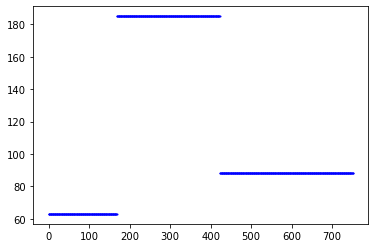

In [206]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [i for i in range(len(mostCommonListLines[0]))]
yList = mostCommonListLines[0]
ax.scatter(xList, yList, s = 1,c = 'blue')

In [207]:
def countSegmentationFun(mostCommonList):
    countSegmentation = 1
    currentValue = mostCommonList[0]
    countDifferentTemp = 0
    for i in range(len(mostCommonList)):
        if mostCommonList[i] ==  currentValue:
            countDifferentTemp = 0
            continue
        else:
            countDifferentTemp += 1
            if countDifferentTemp > 20:
                currentValue = mostCommonList[i]
                countSegmentation += 1
    return countSegmentation

In [208]:
countSegmentationList = []
for mostCommonList in mostCommonListLines:
    countSegmentation = countSegmentationFun(mostCommonList)
    countSegmentationList.append(countSegmentation)
countSegmentationList

[3, 3, 4, 4, 6, 4, 4, 4, 2, 2, 2, 1, 1, 5, 3, 3, 7, 4, 2, 6, 2, 2]

In [209]:
countSegmentation = max(countSegmentationList)
totalNumCluster = countSegmentation**2
numClusterEach = math.ceil(totalNumCluster / 4)
print(numClusterEach)
numCluster0, numCluster1, numCluster2, numCluster3 = numClusterEach,numClusterEach,numClusterEach,numClusterEach

13


In [210]:
kmeans0 = KMeans(n_clusters = numCluster0).fit(pixelCoordList0_sample)
kmeans1 = KMeans(n_clusters = numCluster1).fit(pixelCoordList1_sample)
kmeans2 = KMeans(n_clusters = numCluster2).fit(pixelCoordList2_sample)
kmeans3 = KMeans(n_clusters = numCluster3).fit(pixelCoordList3_sample)

In [211]:
# zCenters0 = [colorGrey0 for i in range(kmeans0.cluster_centers_.shape[0])]
# zCenters1 = [colorGrey1 for i in range(kmeans1.cluster_centers_.shape[0])]
zCenters2 = [colorGrey2 for i in range(kmeans2.cluster_centers_.shape[0])]
# zCenters3 = [colorGrey3 for i in range(kmeans3.cluster_centers_.shape[0])]

In [212]:
# coordCenters0 = kmeans0.cluster_centers_.tolist()
# coordCenters1 = kmeans1.cluster_centers_.tolist()
coordCenters2 = kmeans2.cluster_centers_.tolist()
# coordCenters3 = kmeans3.cluster_centers_.tolist()

In [213]:
zCenters = zCenters0 + zCenters1 + zCenters2 + zCenters3
coordCenters = coordCenters0 + coordCenters1 + coordCenters2 + coordCenters3

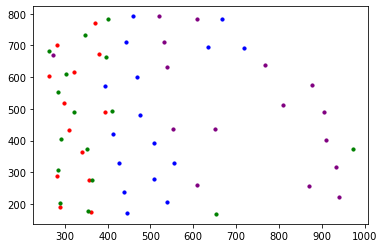

In [216]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [pixelCoord[0] for pixelCoord in coordCenters0]
yList = [pixelCoord[1] for pixelCoord in coordCenters0]
ax.scatter(xList, yList, s = 10,c = 'blue')

xList = [pixelCoord[0] for pixelCoord in coordCenters1]
yList = [pixelCoord[1] for pixelCoord in coordCenters1]
ax.scatter(xList, yList, s = 10,c = 'purple')

# only focus on the category with largest value
xList = [pixelCoord[0] for pixelCoord in coordCenters2]
yList = [pixelCoord[1] for pixelCoord in coordCenters2]
ax.scatter(xList, yList, s = 10,c = 'red')

xList = [pixelCoord[0] for pixelCoord in coordCenters3]
yList = [pixelCoord[1] for pixelCoord in coordCenters3]
ax.scatter(xList, yList, s = 10,c = 'green')
plt.show()

In [217]:
classHighestValues = coordCenters2 # the third color is with the largest value
X = np.array([[coord[0],coord[1]] for coord in classHighestValues])
kdt = KDTree(X, leaf_size=30, metric='euclidean')
queryResults = kdt.query(X, k=len(classHighestValues), return_distance=True)
distanceArray = queryResults[0]
distanceArray

array([[  0.        ,  75.86159542, 101.78301047, 138.38164999,
        190.95697952, 264.35087317, 317.6512767 , 351.31464287,
        441.34807189, 442.46976496, 499.34958432, 532.94734404,
        595.45892541],
       [  0.        ,  60.98470421,  82.29474799,  95.13993361,
         98.48539038, 143.61390329, 162.1243054 , 182.09419276,
        251.66229418, 331.17016545, 340.80490161, 425.18046816,
        442.46976496],
       [  0.        ,  75.60787369,  89.738858  ,  96.97030275,
        137.71190945, 161.23226315, 180.12155573, 190.95697952,
        251.66229418, 252.35352783, 312.1461397 , 342.13100701,
        407.02957676],
       [  0.        ,  87.10207008,  91.64718632,  98.48539038,
        100.47697785, 161.23226315, 174.53929411, 182.22791781,
        233.83672309, 250.8685406 , 260.53380638, 328.60669552,
        351.31464287],
       [  0.        ,  96.85763196, 112.00390619, 162.1243054 ,
        197.8627702 , 260.53380638, 280.26503001, 341.90544135,
        407.

In [218]:
import statistics

In [219]:
distanceList = distanceArray.tolist()
distanceList = [statistics.median(distances) for distances in distanceList]
distanceList

[317.6512766968772,
 162.12430540279607,
 180.1215557288727,
 174.5392941074111,
 280.26503000696357,
 233.06626852715863,
 177.24422552593927,
 217.4876785725239,
 183.4294920098612,
 238.55063220753186,
 177.24422552593927,
 183.4294920098612,
 317.2832611692097]

In [220]:
aveMedianDistanceCenters = sum(distanceList)/len(distanceList)
aveMedianDistanceCenters

218.64897980699587

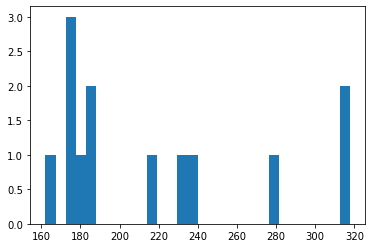

In [221]:
plt.hist(distanceList, 30)
plt.show()

In [222]:
randomPointListMonteCarlo = []

numMonteCarlo = 10000
numClusterCenters = len(distanceList)
for i in range(numMonteCarlo):
    randomPointList = []
    while len(randomPointList) < numClusterCenters:
        x = random.randint(xMin,xMax )
        y = random.randint(yMin,yMax )
        point = Point(x,y)
        if alpha_shape.contains(point):
            randomPointList.append(point)
    randomPointListMonteCarlo.append(randomPointList)
# randomPointListMonteCarlo


In [223]:
# randomPointAveList = []
# for i in range(numClusterCenters):
#     sumX, sumY = 0, 0
#     for randomPointList in randomPointListMonteCarlo:
#         point = randomPointList[i]
#         sumX += point.x
#         sumY += point.y
#     randomPointAveList.append(Point(sumX/numMonteCarlo,sumY/numMonteCarlo))
# len(randomPointAveList)
    

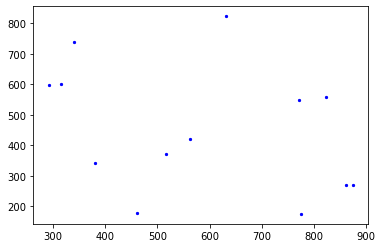

In [224]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [pixelCoord.x for pixelCoord in randomPointList]
yList = [pixelCoord.y for pixelCoord in randomPointList]
ax.scatter(xList, yList, s = 5,c = 'blue')

plt.show()

In [225]:
aveMedianDistanceMonteCarlo = []
for randomPointList in randomPointListMonteCarlo:
    X = np.array([[pixelCoord.x,pixelCoord.y] for pixelCoord in randomPointList])
    kdt = KDTree(X, leaf_size=30, metric='euclidean')
    queryResultsAllRandom = kdt.query(X, k=len(distanceList), return_distance=True)
    distanceArrayAllRandom = queryResultsAllRandom[0]
    distanceListAllRandom = distanceArrayAllRandom.tolist()
    distanceListAllRandom = [statistics.median(distanceAllRandom) for distanceAllRandom in distanceListAllRandom]
    aveMedianDistanceRandom = sum(distanceListAllRandom)/len(distanceListAllRandom)
    aveMedianDistanceMonteCarlo.append(aveMedianDistanceRandom)
# distanceListAllRandom

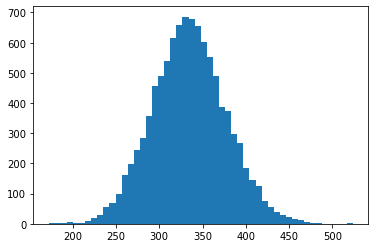

In [226]:
plt.hist(aveMedianDistanceMonteCarlo, 50)
plt.show()

In [227]:
aveMedianDistMontArray = np.asarray(aveMedianDistanceMonteCarlo)

In [228]:
aveMedDistPercentage25 = np.percentile(aveMedianDistMontArray, 2.5)
aveMedDistPercentage25

253.5388385387481

In [229]:
if aveMedianDistanceCenters < aveMedDistPercentage25:
    print('concentrated!')
else:
    print('not concentrated...')

concentrated!


In [109]:
from scipy.stats import ranksums
randomSampleArray = np.asarray(distanceListAllRandom)
mapSampleArray = np.asarray(distanceList)
ranksums(mapSampleArray, randomSampleArray)


RanksumsResult(statistic=-4.409603414449793, pvalue=1.0356009571395687e-05)

In [110]:
ranksums(mapSampleArray, randomSampleArray,alternative = 'less')


RanksumsResult(statistic=-4.409603414449793, pvalue=5.1780047856978435e-06)

In [111]:
ranksums(mapSampleArray, randomSampleArray,alternative = 'greater')

RanksumsResult(statistic=-4.409603414449793, pvalue=0.9999948219952143)

### try to use the random lines to get number of clusters

#### first use a horizontal line as a prototype

In [ ]:
pixelCoordList_sample[0]

In [ ]:
xList = [pixelCoord[0] for pixelCoord in pixelCoordList_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList_sample]
xMin, xMax = min(xList), max(xList)
yMin, yMax = min(yList), max(yList)
yMid = int((yMin + yMax) / 2)
xMin, xMax, yMin, yMax, yMid

In [ ]:
def calculateKNeigh(targetCoord, coordList, k = 6): 
    # targetCoord is the coordinate of current point
    # k nearest neighborhood, only consider the k nearest neighbors
    # CoordList is the set of coordinates to compare
    distList = []
    for j in range(len(coordList)):
        dist = distance(targetCoord, coordList[j])
        distList.append(dist)
    
    neighIndice = sorted(range(len(distList)), key = lambda sub: distList[sub])[:k]
#     [distList[ind] for ind in neighIndice]

    return neighIndice

In [ ]:
def most_common(lst):
    return max(set(lst), key=lst.count)

In [ ]:
def mostCommonListHLine(y,xMin, xMax, pixelCoordList_sample,zList):
    mostCommonList = []
    for x in range(xMin, xMax + 1):
        coord = (x,y)
        neighIndice = calculateKNeigh(coord, pixelCoordList_sample)
        # find the most common class
        zListNeighIndice = [zList[ind] for ind in neighIndice]
        mostCommon = most_common(zListNeighIndice)
        mostCommonList.append(mostCommon)
    return mostCommonList

In [ ]:
def mostCommonListVLine(x,yMin, yMax, pixelCoordList_sample,zList):
    mostCommonList = []
    for y in range(yMin, yMax + 1):
        coord = (x,y)
        neighIndice = calculateKNeigh(coord, pixelCoordList_sample)
        # find the most common class
        zListNeighIndice = [zList[ind] for ind in neighIndice]
        mostCommon = most_common(zListNeighIndice)
        mostCommonList.append(mostCommon)
    return mostCommonList

In [ ]:
mostCommonListLines = []
for y in range(yMin, yMax + 1, int((yMax + 1 - yMin) / 10)):
    print(y)
    mostCommonList = mostCommonListHLine(y, xMin, xMax, pixelCoordList_sample,zList)
    mostCommonListLines.append(mostCommonList)

In [ ]:
for x in range(xMin, xMax + 1, int((xMax + 1 - xMin) / 10)):
    print(x)
    mostCommonList = mostCommonListHLine(x, yMin, yMax, pixelCoordList_sample,zList)
    mostCommonListLines.append(mostCommonList)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [i for i in range(len(mostCommonListLines[0]))]
yList = mostCommonListLines[0]
ax.scatter(xList, yList, s = 1,c = 'blue')

In [ ]:
def countSegmentationFun(mostCommonList):
    countSegmentation = 1
    currentValue = mostCommonList[0]
    countDifferentTemp = 0
    for i in range(len(mostCommonList)):
        if mostCommonList[i] ==  currentValue:
            countDifferentTemp = 0
            continue
        else:
            countDifferentTemp += 1
            if countDifferentTemp > 20:
                currentValue = mostCommonList[i]
                countSegmentation += 1
    return countSegmentation

In [ ]:
countSegmentationList = []
for mostCommonList in mostCommonListLines:
    countSegmentation = countSegmentationFun(mostCommonList)
    countSegmentationList.append(countSegmentation)
countSegmentationList

In [ ]:
countSegmentation = max(countSegmentationList)
totalNumCluster = countSegmentation**2
numClusterEach = math.ceil(totalNumCluster / 4)
print(numClusterEach)
numCluster0, numCluster1, numCluster2, numCluster3 = numClusterEach,numClusterEach,numClusterEach,numClusterEach

In [ ]:
kmeans0 = KMeans(n_clusters = numCluster0).fit(pixelCoordList0_sample)
kmeans1 = KMeans(n_clusters = numCluster1).fit(pixelCoordList1_sample)
kmeans2 = KMeans(n_clusters = numCluster2).fit(pixelCoordList2_sample)
kmeans3 = KMeans(n_clusters = numCluster3).fit(pixelCoordList3_sample)

In [ ]:
pixelCoordList2_sample

In [ ]:
import sys
root = r'C:\Users\jiali\Desktop\choroColorRead\gisalgs'
sys.path.append(root)
# sys.path.append(root + '\\geom')
# sys.path.append(root + '\\indexing')

from geom.point import *
from indexing.extent import *
from indexing.kdtree1 import *
from indexing.kdtree2b import *

import random
from math import sqrt, pi
import numpy as np

In [113]:
def kfunc(tree, p, d, density):
    """
    Input
      tree:    a k-D tree
      p:       a point where the K-function is computed
      d:       radius of the circle around p
      density: density of points in the area
    Return
      n: count of points in the circle
      ld: L(d) value
    """
    neighbors = []
    range_query_circular(tree, p, d, neighbors)
    n = len(neighbors)
#     print('n:' + str(n))
#     print('density:' + str(density))
    kd = float(n)/density
    ld = sqrt(kd/pi)
#     print('ld:' + str(ld))
    return n, ld

In [104]:
n = 87 
ld = sqrt(float(n)/density/pi)
ld

109.6675450682482

In [93]:
len(pixelCoordList2_sample)

1079

In [115]:
points = [Point(pixelCoord[0], pixelCoord[1]) for pixelCoord in pixelCoordList2_sample]
t = kdtree2(points)
centerPoints = [Point(coordCenter[0], coordCenter[1]) for coordCenter in coordCenters2]
print ('number of Points: ' + str(len(pixelCoordList2_sample)))
print ('area: ' + str(maskPolygon.area ))
density =  len(pixelCoordList2_sample) / maskPolygon.area 
print ('density: ' + str(density))
r = d / 2 
radii = r
while radii < coordRange / 2:
    print('radii: ' + str(radii))
    for cp in centerPoints:
        n, ld = kfunc(t, cp, radii, density)
#         print('n: ' + str(n))
        print('ld: ' + str(ld))
    radii = radii + r

number of Points: 1079
area: 468606.5
density: 0.0023025715605737435
radii: 54.142857142857146
ld: 109.6675450682482
ld: 108.39966956677493
radii: 108.28571428571429
ld: 197.0932066688026
ld: 205.33756856531255
radii: 162.42857142857144
ld: 253.26634666607404
ld: 269.65679447400913
radii: 216.57142857142858
ld: 305.0183922661091
ld: 307.0511178559658
radii: 270.7142857142857
ld: 321.7802645079276
ld: 331.0968806364952
radii: 324.8571428571429
ld: 347.19761878802217
ld: 354.2920601933628


In [112]:
n = 1079*pi * r**2/maskPolygon.area 
n

21.205345308639707

In [109]:
kd = n / density
kd

9209.418578659011

In [111]:
ld = sqrt(kd / pi)
ld

54.142857142857146

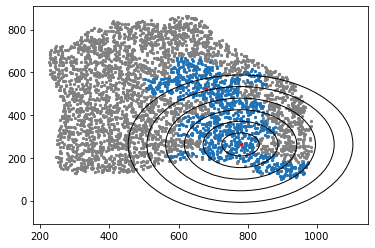

In [89]:
fig = plt.figure()
ax = fig.add_subplot()
xList = [pixelCoord[0] for pixelCoord in centerPoints]
yList = [pixelCoord[1] for pixelCoord in centerPoints]
ax.scatter(xList, yList, s = 10,c = 'red')
xList = [pixelCoord[0] for pixelCoord in pixelCoordList0_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList0_sample]
ax.scatter(xList, yList, s = 5,c = 'grey')


xList = [pixelCoord[0] for pixelCoord in pixelCoordList1_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList1_sample]
ax.scatter(xList, yList, s = 5,c = 'grey')

xList = [pixelCoord[0] for pixelCoord in pixelCoordList2_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList2_sample]
ax.scatter(xList, yList, s = 5,c = np.asarray(colorList[2])/255.0)

xList = [pixelCoord[0] for pixelCoord in pixelCoordList3_sample]
yList = [pixelCoord[1] for pixelCoord in pixelCoordList3_sample]
ax.scatter(xList, yList, s = 5,c ='grey')

centerPoint = centerPoints[0]
circle1 = plt.Circle((centerPoint[0], centerPoint[1]), r, fill=False)
circle2 = plt.Circle((centerPoint[0], centerPoint[1]), 2*r, fill=False)
circle3 = plt.Circle((centerPoint[0], centerPoint[1]), 3*r, fill=False )
circle4 = plt.Circle((centerPoint[0], centerPoint[1]), 4*r, fill=False)
circle5 = plt.Circle((centerPoint[0], centerPoint[1]), 5*r, fill=False)
circle6 = plt.Circle((centerPoint[0], centerPoint[1]), 6*r, fill=False )

ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
ax.add_patch(circle4)
ax.add_patch(circle5)
ax.add_patch(circle6)
plt.show()